In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [1]:
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import seaborn as sns

In [2]:
from movienet import MovieNet

Using TensorFlow backend.


In [3]:
ratings_raw = pd.read_csv("ratings.csv")
movies_raw = pd.read_csv("movies.csv")

In [4]:
def load_obj(name):  
    with open(Path("model")/str(name+'.pkl'), 'rb') as f:
        return pickle.load(f)

user2idx = load_obj("user2idx")
idx2user = load_obj("idx2user")
movie2idx = load_obj("movie2idx")
idx2movie = load_obj("idx2movie")

In [5]:
ratings = ratings_raw.copy()
ratings["userId"] = ratings["userId"].apply(lambda x: user2idx[x])
ratings["movieId"] = ratings["movieId"].apply(lambda x: movie2idx[x])

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
4,0,4,5.0,964982931


In [7]:
n_users = len(user2idx)
n_movies = len(movie2idx)
n_users, n_movies

(610, 9724)

In [8]:
movie_model = MovieNet(n_users, n_movies)
movie_model.load_model(name="movie_model")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [9]:
X_pred = pd.DataFrame({"userId": [0 for _ in range(n_movies)], "movieId": [i for i in range(n_movies)]})

In [10]:
def predict_user(user_id):
    X_pred["userId"] = X_pred.userId.apply(lambda x: user_id)
    preds = movie_model.predict(X_pred)
    df_preds = pd.DataFrame({"pred": preds, "movieId": [i for i in range(n_movies)],
                             "title": [movies_raw.loc[movies_raw.movieId == idx2movie[i]]["title"].values[0] for i in range(n_movies)]})
    return df_preds

def suggest_user(user_id, m=10):
    preds = predict_user(user_id)
    preds.sort_values("pred", ascending=False, inplace=True)
    r = ratings[ratings.userId == 0]["movieId"].values
    preds.drop(r, axis=0, inplace=True)
    return preds.drop("movieId", axis=1)[:m]

def user_rating(user_id):
    preds = predict_user(user_id)
    return pd.merge(ratings[ratings.userId == user_id][["rating", "movieId"]], preds, on="movieId")

In [11]:
user_id = np.random.randint(0, n_users)
user_id

52

In [12]:
preds = user_rating(user_id).sort_values("rating", ascending=False)[:]
preds

,rating,movieId,pred,title
0,5.0,2423,4.905826,"To Wong Foo, Thanks for Everything! Julie Newm..."
1,5.0,2432,5.339506,Immortal Beloved (1994)
18,5.0,2191,5.370090,"River Runs Through It, A (1992)"
17,5.0,2093,5.461766,"Red Violin, The (Violon rouge, Le) (1998)"
16,5.0,169,5.115817,Dick Tracy (1990)
15,5.0,2998,5.362842,Halloween (1978)
14,5.0,1478,5.145308,Benny & Joon (1993)
13,5.0,90,5.297379,Pink Floyd: The Wall (1982)
12,5.0,82,5.185335,Duck Soup (1933)
11,5.0,2997,4.988126,"Return of the Pink Panther, The (1975)"


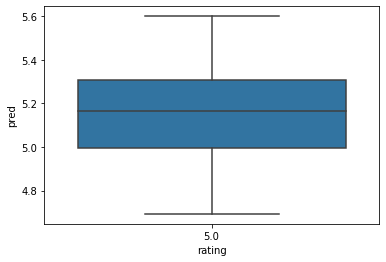

In [13]:
sns.boxplot(preds["rating"], preds["pred"])

In [14]:
suggest_user(user_id)

,pred,title
3868,5.878429,My Left Eye Sees Ghosts (Ngo joh aan gin diy g...
6880,5.877537,Nasu: Summer in Andalusia (2003)
8227,5.875249,Crossing Delancey (1988)
6714,5.870805,Reform School Girls (1986)
8283,5.866981,Lady Jane (1986)
7399,5.866838,Bad Boy Bubby (1993)
3975,5.866366,Bloodsucking Bastards (2015)
3966,5.865011,Hollywood Chainsaw Hookers (1988)
3866,5.863652,Goodbye Charlie (1964)
3987,5.861557,A Perfect Day (2015)


In [15]:
import nmslib

ModuleNotFoundError: No module named 'nmslib'

In [ ]:
movies_index = nmslib.init(space='angulardist', method='hnsw')
movies_index.addDataPointBatch(movie_model.model.get_layer("movies").get_weights()[0])

In [ ]:
M = 100
efC = 1000
efS = 1000
num_threads = 6
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
query_time_params = {'efSearch': efS}

In [ ]:
movies_index.createIndex(index_time_params)
movies_index.setQueryTimeParams(query_time_params)

In [ ]:
def get_knns(index, vecs, n_neighbour):
     return zip(*index.knnQueryBatch(vecs, k=n_neighbour, num_threads=6))

def get_knn(index, vec, n_neighbour):
    return index.knnQuery(vec, k=n_neighbour)

def suggest_movies_knn(movieId, n_suggest = 5):
    res = get_knn(movies_index, movie_model.model.get_layer("movies").get_weights()[0][movieId], n_suggest)[0]
    return movies_raw[movies_raw.movieId.isin([idx2movie[i] for i in res])]

user 19494 loved the movie "Star Wars: Episode IV - A New Hope", let see what movies that are closes in the embedding space.

In [ ]:
movie_id = 9 # movieId of Star Wars: Episode IV - A New Hope
suggest_movies_knn(movie_id, 10)

In [16]:
users_index = nmslib.init(space='angulardist', method='hnsw')
users_index.addDataPointBatch(movie_model.model.get_layer("users").get_weights()[0])

NameError: name 'nmslib' is not defined

In [17]:
M = 100
efC = 1000
efS = 1000
num_threads = 6
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
query_time_params = {'efSearch': efS}

In [72]:
users_index.createIndex(index_time_params)
users_index.setQueryTimeParams(query_time_params)

In [73]:
def suggest_users_knn(user_id, n_suggest = 5):
    res = get_knn(users_index, movie_model.model.get_layer("users").get_weights()[0][user_id], n_suggest)[0]
    for uid in res[1:]:
        moviesId = ratings[ratings.userId == uid].sort_values("rating", ascending=False)[:10]["movieId"].values
        print("From user", uid, ": ")
        display(movies_raw[movies_raw.movieId.isin([idx2movie[i] for i in moviesId])])

In [74]:
suggest_users_knn(user_id)

From user 45925 : 


,movieId,title,genres
1179,1204,Lawrence of Arabia (1962),Adventure|Drama|War
1875,1959,Out of Africa (1985),Drama|Romance
2311,2396,Shakespeare in Love (1998),Comedy|Drama|Romance
2600,2686,"Red Violin, The (Violon rouge, Le) (1998)",Drama|Mystery
3320,3408,Erin Brockovich (2000),Drama
3379,3468,"Hustler, The (1961)",Drama
3487,3578,Gladiator (2000),Action|Adventure|Drama
4899,4995,"Beautiful Mind, A (2001)",Drama|Romance
4914,5010,Black Hawk Down (2001),Action|Drama|War
5386,5483,"Kid Stays in the Picture, The (2002)",Documentary


From user 95301 : 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1839,1923,There's Something About Mary (1998),Comedy|Romance
4211,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
4877,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
4899,4995,"Beautiful Mind, A (2001)",Drama|Romance
6271,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy
7249,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
7761,8360,Shrek 2 (2004),Adventure|Animation|Children|Comedy|Musical|Ro...
9568,30707,Million Dollar Baby (2004),Drama
9582,30793,Charlie and the Chocolate Factory (2005),Adventure|Children|Comedy|Fantasy|IMAX


From user 33127 : 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
108,110,Braveheart (1995),Action|Drama|War
166,168,First Knight (1995),Action|Drama|Romance
221,224,Don Juan DeMarco (1995),Comedy|Drama|Romance
227,230,Dolores Claiborne (1995),Drama|Thriller
245,248,Houseguest (1994),Comedy
250,253,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
258,261,Little Women (1994),Drama
262,265,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance
345,349,Clear and Present Danger (1994),Action|Crime|Drama|Thriller


From user 77097 : 


,movieId,title,genres
1149,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
1625,1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
3920,4014,Chocolat (2000),Drama|Romance
5121,5218,Ice Age (2002),Adventure|Animation|Children|Comedy
5519,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy
6271,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy
8885,26502,"Christmas Carol, A (1984)",Drama|Fantasy
13172,63876,Milk (2008),Drama
15203,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX
16936,85736,BURN-E (2008),Adventure|Animation|Children|Sci-Fi
